# Test Patch Generator
### On this notebook, we will generate the patches to be used for testing.

### We can choose the patch zise, the stride to generate patches, which type of images will be used for validation, the minimum amount of positive pixels for a patch to be considered as positive, and some other features of the patches to be generated (see full explanation further below).

### Data was already downloaded into the Git Repository, in the folder '../Data', which contains the following subfolders:
    1. Serial: Folder containing all 'Serial' type images.
    2. Control: Folder containing all 'Control' type images.
    3. Streak: Folder containing all 'Streak' type images.

### In addition, <span style="color:blue">*prepocessed images*</span>  can already be found in <span style="color:blue">'../Data/no_dish_border/'</span> folder also containing the following subfolders:
    1. Serial: Folder containing all pre-processed 'Serial' type images.
    2. Control: Folder containing all pre-processed 'Control' type images.
    3. Streak: Folder containing all pre-processed 'Streak' type images.
    
### Positive pixel <span style="color:blue">*Masks*</span> were already obtained and can be found in <span style="color:blue">'../Data/Masks'</span> folder also containing the following subfolders:
    1. Serial: Folder containing all positive masks for 'Serial' type images.
    2. Control: Folder containing all positive masks for 'Control' type images.
    3. Streak: Folder containing all positive masks for 'Streak' type images.
    
### Using the positive pixel masks, <span style="color:blue">*positive-pixels-only images*</span> were generated and can be found in <span style="color:blue">'../Data/pos_pixel_only/'</span> folder also containing the following subfolders:
    1. Serial: Folder containing all positive-pixels-only images for 'Serial' type images.
    2. Control: Folder containing all positive-pixels-only images for 'Control' type images.
    3. Streak: Folder containing all positive-pixels-only images for 'Streak' type images.

### Let's import necessary libraries / modules:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from PIL import Image, ImageOps
import cv2 as cv

%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Helper Function: get a list of 'complete' file paths of all images in a given folder:

In [2]:
def get_files(folder):
    """
    Returns a list of file_paths for each file in the specified folder. 
    :param folder: The folder where files are located.
    :return: A list of file_paths for each file in the specified folder.
    """
    files = os.listdir(folder)
    paths = []
    for x in files:
        paths.append(os.path.join(folder, x))
    return paths

### Helper Function: 
#### Create all needed folders and subfolders.

In [3]:
def create_folders(patch_size):
    """
    Create all needed folders to save the created Patches.
    :param patch_size: Tuple. (Patch_width, Patch_height) e.g. (64 ,64).
    :return: save_dir. The root directory where Patches will be saved.
    """ 
    folder_name = 'Patches_' + str(patch_size[0]) + 'x' + str(patch_size[1])
    save_dir = '../' + folder_name + '/'
    
    if folder_name in os.listdir('../'):
        shutil.rmtree(save_dir)
    os.mkdir(save_dir)
    
    for folder in ['mixed_colony_images_nogt', 'mixed_colony_images_gt']:
        path = save_dir + '/' + folder
        os.mkdir(path)
    return save_dir

## Patch Generator function

In [10]:
def create_patches(img_types, patch_size, stride, rotations=False, flips=['None']):
    """
    Creates patches for training.
    :param img_types: List. List of images types patching. List should contain either
                      'mixed_colony_images_nogt' or 'mixed_colony_images_gt' or both.
    :param patch_size: Tuple. (patch_width, patch_height) e.g. (128,128).
    :param stride: Tuple. (horizontal_stride, vertical_stride).
                   Amount of pixels to move right or down  to generate next patch.
    :param rotations: List of Int [0-360] or False. List with the amount of degrees to rotate the
                      training images around its center (before patching), for data augmentation. 
                      If rotations = False, then no rotation will be performed on training images.
    :param flips: List with any combination from ['None', 'hoz', 'vert', 'both'].
                  Patches will be generated from every flip setup included within the list.
                  If flips = ['None'], no flips will be performed on training images (default).t).                     
    :return: save_dir. The root directory where Patches were saved.
    """ 
    save_dir = create_folders(patch_size)
    width, height = patch_size
    root = '../'
    
    for type_ in img_types:            
        print('\ngenerating "{}" patches...............'.format(type_)) 
        img_folder = root + type_
        images = get_files(img_folder) # Returns array of all file_paths in the specified folder.
        move = stride
        
        if rotations and type(rotations) is list:
            degrees = [int(rot) for rot in rotations]
        else:
            degrees = [0]
        
        """Setup the flip operations to be performed"""
        if flips and type(flips) is list:
            flip_list = [flip for flip in flips if flip in ['None', 'hoz', 'vert', 'both']]
        else:
            flip_list = ['None']   
        flip_operations = []
        for flip in flip_list:
            if flip == 'hoz':
                operations = {'hoz_flip': [ImageOps.mirror]}
            if flip == 'vert' or flip == 'both':
                operations = {'vert_flip': [ImageOps.flip]}
            if flip == 'both':
                operations = {'hoz+vert_flip': [ImageOps.mirror,ImageOps.flip]}
            if flip == 'None':
                operations = {'no_flip': [None]}
            flip_operations.append(operations)
            
        for img_path in images:
            original_img = Image.open(img_path)
            imgwidth, imgheight = original_img.size
            print(imgwidth, imgheight)
            
            for angle in degrees:
                rot_img = original_img.rotate(angle, fillcolor='white')
                rot_img = ImageOps.expand(rot_img, border=(0,0,width,height), fill='white') #expand for patching
            
                for ops_dict in flip_operations: #nested list of flip operations to be performed
                    for name, ops in ops_dict.items(): #list of flip operations in be performed ('both'='hoz'+'vert')
                        flip = name
                        img = rot_img
                        for op in ops:
                            if op:
                                img = op(img)

                    for i in range(0,imgheight,move[1]):
                        for j in range(0,imgwidth,move[0]):
                            box = (j, i, j+width, i+height)
                            patch = img.crop(box)

                            pos_save_path = save_dir+type_+img_path[:-4][len(img_folder):] \
                                + '_' + '{}_{}_rot_{}_{}.jpg'.format(int(i/move[1]),int(j/move[0]),angle,flip)
                            patch.save(pos_save_path)
                            
    print("\npatches sucesfully created and saved in: '{}\n'".format(save_dir))
    return save_dir

# Detailed explanation of the parameters for the Patch Generator function:


## img_types:
This is a list containing strings describing the type of images for which you wish to generate the patches. <br>
The list should contain either 'mixed_colony_images_nogt' or 'mixed_colony_images_gt' or both.

## patch_size:
This is a tuple containing the size of the patches to be generate, in pixels (patch_width, patch_height).<br>
As example, if you want to generate patches of 64 pixels width by 64 pixels height, use:  __patch_size = (64, 64)__

## stride:
Tuple with (horizontal_stride, vertical_stride). To generate the patches, a window with the desire patch_size will move around the original image, extracting the patches. This window will move from the left corner first horizontally (first 'row') and then it will move vertically before moving horizontally again (second row). <br>

The horizontal stride will then correspond to the amount of pixels that the window will move to the right to generate the next patch. Similarly, the vertical stride will correspond to the amount of pixels that the window will move down to the next row of patches. <br>

As a toy example, in the picture below, the original image size is (6, 6) = 6x6 pixels, the patch_size is (3, 3) and the horizontal stride is 2:

![alt text](../../../notebook_pictures/stride.png "toy example for stride")
<br><br>
If horizontal_stride = patch_width, no patches will be overlapping horizontally. <br>
If horizontal_stride > patch_width, we will be loosing data which is not recommended. <br>
If horizontal_stride < patch_width, we will be getting overlapping patches which is highly recommended as a __Data Augmentation__ technique. <br><br>
The same applies for the vertical_stride and the patch_height.

## rotations:
List of integers from 0 to 360 or False. List with the amount of degrees to rotate the training images around the image center, for data augmentation. Rotations will be performed before extracting the patches so no information is lost. The image will be rotated as many times as the lenght of the list. As example, if __rotations = [0, 90, 180, 270]__, pathecs will be extracted from the original images rotated at 0, 90, 180 and 270 degrees.<br><br>

If __rotations = [0] or [360] or None / False__, then no rotations will be performed for training images.

## flips:
List with any combination from ['None', 'hoz', 'vert', 'both']. The patches will be generated from every setup included within the list. Possible setups to be included in the list are:
- 'hoz'. When this is included in the list, patches will be generated from horizontally-flipped images.
- 'vert'. When this is included in the list, patches will also be generated from vertically-flipped images.
- 'None'. When this is included in the list, patches will also be generated from non-flipped images. 
- 'both'. When this is included in the list, patches will also be generated from images that were first both horizontally-flipped and vertically flipped.

Examples:

- if __flips = ['None', 'both']__, patches will be generated first from non-flipped images and then from images that were first both horizontally-flipped and vertically flipped.

- If __flips = ['None']__, then patches will be generated from from non-flipped images only.

- If __flips = ['hoz']__, then patches will be generated from horizontally-flipped images only.

## Enter the parameters for the Patch Generator function:

In [11]:
img_types = ['mixed_colony_images_nogt', 'mixed_colony_images_gt']
patch_size = (128, 128)             # (patch_width, patch_height) 
stride = (128, 128)                 # (Horizontal_stride, Vertical_stride)
rotations = [0]                     # List of Int. with degrees used for image rotations. False-> no rotation
flips=['None']                      # List with any combination from ['None', 'hoz', 'vert', 'both']

## Let's generate the patches!:

###  *NOTE: <span style="color:red">THIS WILL REPLACE PREVIOUS PATCHES OF THE SAME SIZE, UNLESS YOU RENAME THE PREVIOUS PATCH FOLDER*</span>

In [12]:
"""Be CAREFUL, this will replace previously produced Patches of the same size"""
patch_dir = create_patches(img_types, patch_size, stride, rotations, flips)

# Let's count patches by type and location:
grand_total = 0
for type_ in ['mixed_colony_images_nogt', 'mixed_colony_images_gt']:
    folder = '{}{}'.format(patch_dir,type_)
    n = len(os.listdir(folder))
    print("Total '{}' Patches: {}".format(type_,n))
    grand_total += n
print('GRAND TOTAL: {}'.format(grand_total))


generating "mixed_colony_images_nogt" patches...............
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402
1450 1402

generating "mixed_colony_images_gt" patches...............
1461 1413
1530 1418
1461 1413
1461 1413
1461 1413
1461 1413
1461 1413
1461 1413
1461 1413
1461 1397
1461 1413
1461 1413
1530 1418
1461 1413
1461 1413
1461 1413
1461 1413
1461 1413
1461 1413
1461 1413
1461 1413
1461 1413
1461 1413
1461 1413
1461 1413
1461 1413
1461 1413
1461 1413
1461 1413
1461 1413

patches sucesfully created and saved in: '../Patches_128x128/
'
Total 'mixed_colony_images_nogt' Patches: 3960
Total 'mixed_colony_images_gt' Patches: 4308
GRAND TOTAL: 8268


###  <span style="color:red">EXTRAS (in case you want to use them):</span>
### Let's separate patches by image in different folders:

In [7]:
for type_ in ['mixed_colony_images_nogt', 'mixed_colony_images_gt']: 
    root = '{}{}/'.format(patch_dir,type_)   
    for img in os.listdir(root):
        source = root + img
        dest = '{}'.format(img[:15])
        if dest not in os.listdir(root):
            os.mkdir(root + dest)
        shutil.move(source, root+dest)

### Let's visualize all patches for a random image of each type:


Patches for mixed_colony_images_nogt/Mixed-colony_29:


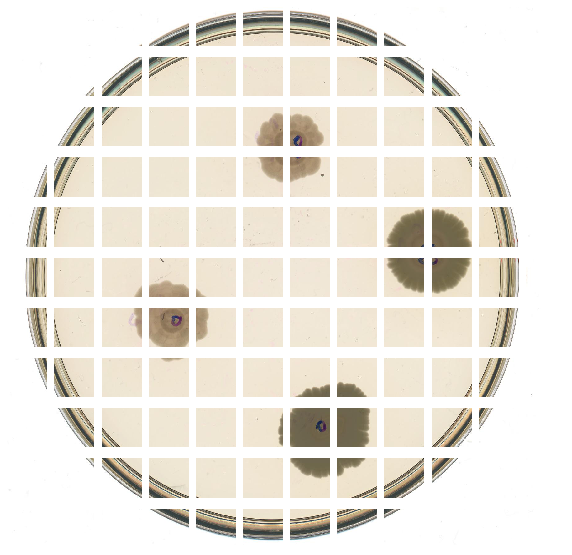


Patches for mixed_colony_images_gt/Mixed-colony_07:


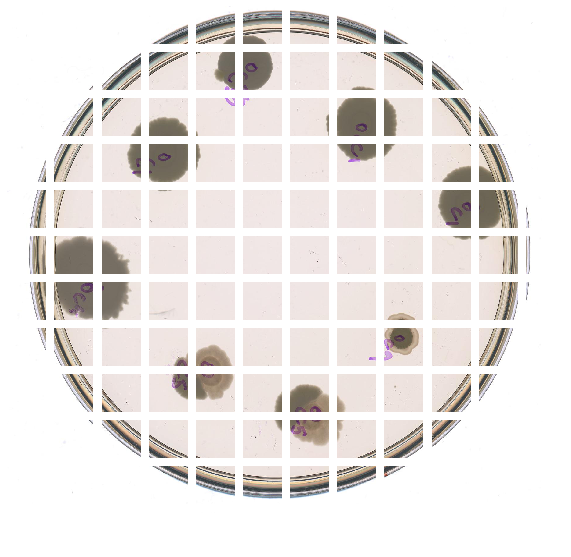

In [8]:
for type_ in img_types:
    img_folder = '../' + type_
    images = os.listdir(img_folder)
    img = images[np.random.choice(range(len(images)))]
    original_img = Image.open(img_folder + '/' + img)
    imgwidth, imgheight = original_img.size
    
    root = '{}{}/'.format(patch_dir,type_)
    patch_folder = root + img[:15]
    print('\nPatches for {}/{}:'.format(type_,img[:15]))
    patches = get_files(patch_folder)

    fig_height = len(range(0,imgheight,stride[1]))
    fig_width = len(range(0,imgwidth,stride[0]))
    sorted_patches = []
    for j in range(fig_height):
        for k in range(fig_width):
            for patch in patches:
                if '_{}_{}_'.format(j,k) in patch:
                    sorted_patches.append(patch)              
    i = 0
    fig, axes1 = plt.subplots(fig_height,fig_width,figsize=(10,10))
    for j in range(fig_height):
        for k in range(fig_width):
            axes1[j][k].set_axis_off()
            patch = Image.open(sorted_patches[i])
            axes1[j][k].imshow(np.asarray(patch))
            i += 1
    plt.show()